# Train agent online with GPU

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Jul 28 13:51:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pyproj &> /dev/null
!pip install pyro-ppl &> /dev/null

In [3]:
import sys
cwd = "drive/Shareddrives/Active_Inference_Interaction/"
sys.path.append(cwd)

In [4]:
import argparse
import os
import json
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch 

# setup imports
from src.simulation.observers import ACTION_SET, FEATURE_SET
from src.data.train_utils import load_data, count_parameters
from src.data.data_filter import filter_segment_by_length
from src.data.ego_dataset import EgoDataset, RelativeDataset
from src.map_api.lanelet import MapReader
from src.simulation.simulator import InteractionSimulator
from src.simulation.observers import Observer

# model imports
from src.agents.vin_agent import VINAgent
from src.agents.hyper_vin_agent import HyperVINAgent
from src.agents.mlp_agents import MLPAgent

# training imports
from src.algo.irl import BehaviorCloning
from src.algo.airl import DAC
from src.algo.recurrent_airl import RecurrentDAC
from src.algo.rl_utils import train
from src.visualization.utils import plot_history
from src.visualization.animation import animate, save_animation

import warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

device: cuda


In [5]:
class SaveCallback:
    def __init__(self, arglist, map_data, cp_history=None):
        date_time = datetime.datetime.now().strftime("%m-%d-%Y %H-%M-%S")
        exp_path = os.path.join(arglist["exp_path"], "agents")
        agent_path = os.path.join(exp_path, arglist["agent"])
        save_path = os.path.join(agent_path, date_time)
        test_eps_path = os.path.join(save_path, "test_episodes")
        model_path = os.path.join(save_path, "models") # used to save model checkpoint
        if not os.path.exists(exp_path):
            os.mkdir(exp_path)
        if not os.path.exists(agent_path):
            os.mkdir(agent_path)
        if not os.path.exists(save_path):
            os.mkdir(save_path)
        if not os.path.exists(test_eps_path):
            os.mkdir(test_eps_path)
        if not os.path.exists(model_path):
            os.mkdir(model_path)
        
        # save args
        with open(os.path.join(save_path, "args.json"), "w") as f:
            json.dump(arglist, f)

        self.save_path = save_path
        self.test_eps_path = test_eps_path
        self.model_path = model_path
        self.cp_history = cp_history
        self.cp_every = arglist["cp_every"]
        self.map_data = map_data

        self.num_test_eps = 0
        self.iter = 0

    def __call__(self, model, logger):
        # save history
        df_history = pd.DataFrame(logger.history)
        df_history = df_history.assign(train=1)
        if self.cp_history is not None:
            df_history["epoch"] += self.cp_history["epoch"].values[-1] + 1
            df_history["time"] += self.cp_history["time"].values[-1]
            df_history = pd.concat([self.cp_history, df_history], axis=0)
        df_history.to_csv(os.path.join(self.save_path, "history.csv"), index=False)
        
        # save history plot
        fig_history, _ =plot_history(df_history, model.plot_keys)
        fig_history.savefig(os.path.join(self.save_path, "history.png"), dpi=100)
        
        # save test episode
        if len(logger.test_episodes) > self.num_test_eps:
            ani = animate(self.map_data, logger.test_episodes[-1]["sim_states"], logger.test_episodes[-1]["track_data"])
            save_animation(ani, os.path.join(self.test_eps_path, f"epoch_{self.num_test_eps+1}_ani.mp4"))
            self.num_test_eps += 1
        
        plt.clf()
        plt.close()
    
        if (self.iter + 1) % self.cp_every == 0:
            # save model
            cpu_state_dict = {k: v.cpu() for k, v in model.state_dict().items()}
            torch.save(cpu_state_dict, os.path.join(self.model_path, f"model_{self.iter}.pt"))
            print(f"\ncheckpoint saved at: {self.save_path}\n")
        self.iter += 1

    def save_model(self, model):
        cpu_state_dict = {k: v.cpu() for k, v in model.state_dict().items()}
        torch.save(cpu_state_dict, os.path.join(self.save_path, "model.pt"))

In [6]:
def main(arglist):
    np.random.seed(arglist["seed"])
    torch.manual_seed(arglist["seed"])
    
    df_track = load_data(arglist["data_path"], arglist["scenario"], arglist["filename"], train=True)

    # filter episode length
    df_track["eps_id"], df_track["eps_len"] = filter_segment_by_length(
        df_track["eps_id"].values, arglist["min_eps_len"]
    )
    
    """ TODO: add code to adapt input feature set """
    # define feature set
    ego_features = ["d", "ds", "dd", "kappa_r", "psi_error_r", ]
    relative_features = ["s_rel", "d_rel", "ds_rel", "dd_rel", "loom_s"]
    feature_set = ego_features + relative_features
    assert set(ego_features).issubset(set(FEATURE_SET["ego"]))
    assert set(relative_features).issubset(set(FEATURE_SET["relative"]))

    # define action set
    if arglist["action_set"] == "frenet":
        action_set = ["dds", "ddd"]
    else:
        action_set = ["ax_ego", "ay_ego"]
    assert set(action_set).issubset(set(ACTION_SET))
    
    # compute obs and ctl mean and variance stats
    obs_mean = torch.from_numpy(df_track.loc[df_track["is_train"] == 1][feature_set].mean().values).to(torch.float32)
    obs_var = torch.from_numpy(df_track.loc[df_track["is_train"] == 1][feature_set].var().values).to(torch.float32)
    ctl_mean = torch.from_numpy(df_track.loc[df_track["is_train"] == 1][action_set].mean().values).to(torch.float32)
    ctl_var = torch.from_numpy(df_track.loc[df_track["is_train"] == 1][action_set].var().values).to(torch.float32)

    # compute ctl limits
    ctl_max = torch.from_numpy(df_track.loc[df_track["is_train"] == 1][action_set].max().values).to(torch.float32)
    ctl_min = torch.from_numpy(df_track.loc[df_track["is_train"] == 1][action_set].min().values).to(torch.float32)
    ctl_lim = torch.max(torch.abs(ctl_max), torch.abs(ctl_min)) * 1.2

    ego_dataset = EgoDataset(
        df_track, train_labels_col="is_train", 
        max_eps=arglist["max_data_eps"], create_svt=arglist["create_svt"], seed=arglist["seed"]
    )
    rel_dataset = RelativeDataset(
        df_track, feature_set, action_set, train_labels_col="is_train", 
        max_eps=arglist["max_data_eps"], seed=arglist["seed"]
    )
    obs_dim, ctl_dim = len(feature_set), 2 

    print(f"feature set: {feature_set}")
    print(f"action set: {action_set}")
    print(f"data size: {len(ego_dataset)}")
    
    if arglist["agent"] == "mlp":
        agent = MLPAgent(
            obs_dim, ctl_dim, arglist["hidden_dim"], arglist["num_hidden"], 
            activation=arglist["activation"], use_tanh=arglist["use_tanh"], 
            ctl_limits=ctl_lim, norm_obs=arglist["norm_obs"]
        )
    elif arglist["agent"] == "vin":
        agent = VINAgent(
            arglist["state_dim"], arglist["act_dim"], obs_dim, ctl_dim, arglist["hmm_rank"],
            arglist["horizon"], obs_cov=arglist["obs_cov"], ctl_cov=arglist["ctl_cov"], 
            use_tanh=arglist["use_tanh"], ctl_lim=ctl_lim
        )
        agent.obs_model.init_batch_norm(obs_mean, obs_var)
        if not arglist["use_tanh"]:
            agent.ctl_model.init_batch_norm(ctl_mean, ctl_var)
    elif arglist["agent"] == "hvin":
        agent = HyperVINAgent(
            arglist["state_dim"], arglist["act_dim"], obs_dim, ctl_dim, arglist["hmm_rank"],
            arglist["horizon"], arglist["hyper_dim"], arglist["hidden_dim"], arglist["num_hidden"], 
            arglist["gru_layers"], arglist["activation"], 
            obs_cov=arglist["obs_cov"], ctl_cov=arglist["ctl_cov"], 
            use_tanh=arglist["use_tanh"], ctl_lim=ctl_lim
        )
        agent.obs_model.init_batch_norm(obs_mean, obs_var)
        if not arglist["use_tanh"]:
            agent.ctl_model.init_batch_norm(ctl_mean, ctl_var)

    # init trainer
    if arglist["algo"] == "dac":
        model = DAC(
            agent, arglist["hidden_dim"], arglist["num_hidden"], 
            gamma=arglist["gamma"], beta=arglist["beta"], polyak=arglist["polyak"], norm_obs=arglist["norm_obs"],
            buffer_size=arglist["buffer_size"], batch_size=arglist["batch_size"], 
            d_steps=arglist["d_steps"], a_steps=arglist["a_steps"], 
            lr=arglist["lr_d"], decay=arglist["decay"], grad_clip=arglist["grad_clip"], grad_penalty=arglist["grad_penalty"]
        )
        model.fill_real_buffer(rel_dataset)
    elif arglist["algo"] == "rdac":
        assert "vin" in arglist["agent"]
        model = RecurrentDAC(
            agent, arglist["hidden_dim"], arglist["num_hidden"], arglist["activation"],
            gamma=arglist["gamma"], beta=arglist["beta"], polyak=arglist["polyak"], 
            norm_obs=arglist["norm_obs"], use_state=arglist["use_state"],
            buffer_size=arglist["buffer_size"], d_batch_size=arglist["d_batch_size"], a_batch_size=arglist["a_batch_size"],
            rnn_len=arglist["rnn_len"], d_steps=arglist["d_steps"], a_steps=arglist["a_steps"], 
            lr_d=arglist["lr_d"], lr_a=arglist["lr_a"], lr_c=arglist["lr_c"], decay=arglist["decay"], grad_clip=arglist["grad_clip"], 
            grad_penalty=arglist["grad_penalty"], bc_penalty=arglist["bc_penalty"], obs_penalty=arglist["obs_penalty"]
        )
        model.fill_real_buffer(rel_dataset)
    
    # load agent from checkpoint
    cp_history = None
    if arglist["checkpoint_path"] != "none":
        cp_path = os.path.join(
            arglist["exp_path"], "agents", 
            arglist["agent"], arglist["checkpoint_path"]
        )
        # load state dict
        state_dict = torch.load(os.path.join(cp_path, "model.pt"))

        # load history
        cp_history = pd.read_csv(os.path.join(cp_path, "history.csv"))
        
        model.load_state_dict(state_dict, strict=True)

        print(f"loaded checkpoint from {cp_path}")

    print(f"num parameters: {count_parameters(model)}")
    model.to(device)
    print(model)
    
    # for n, p in model.named_parameters():
    #     print(n, p.device)
    # raise ValueError

    # load map
    map_data = MapReader()
    map_data.parse(os.path.join(arglist["data_path"], "maps", arglist["scenario"] + ".osm"))
    
    # init simulator
    observer = Observer(
        map_data, ego_features=ego_features, relative_features=relative_features,
        action_set=action_set
    )
    env = InteractionSimulator(ego_dataset, map_data, observer, max_eps_steps=arglist["max_eps_len"])
    
    callback = None
    if arglist["save"]:
        callback = SaveCallback(arglist, map_data, cp_history=cp_history)

    model, logger = train(
        env, model, arglist["epochs"], arglist["steps_per_epoch"], 
        arglist["update_after"], arglist["update_every"], 
        log_test_every=arglist["log_test_every"], verbose=arglist["verbose"],
        callback=callback
    )
    callback.save_model(model)

    return model

In [13]:
# train config
arglist = {
    "data_path": os.path.join(cwd, "interaction-dataset-master"),
    "exp_path": os.path.join(cwd, "exp"),
    "scenario": "DR_CHN_Merging_ZS",
    "filename": "vehicle_tracks_007.csv",
    "checkpoint_path": "none",
    # agent args
    "agent": "hvin",
    "state_dim": 30,
    "act_dim": 60,
    "hmm_rank": 32,
    "horizon": 30,
    "obs_cov": "tied",
    "ctl_cov": "tied",
    "action_set": "frenet",
    "use_tanh": True,
    "hyper_dim": 4,
    # trainer model args
    "algo": "rdac",
    "hidden_dim": 64,
    "num_hidden": 2,
    "gru_layers": 2,
    "activation": "relu",
    "gamma": 0.9,
    "beta": 0.2,
    "polyak": 0.995,
    "norm_obs": True,
    "use_state": False,
    # data args
    "max_data_eps": 100, # number of data episodes
    "create_svt": True,
    "min_eps_len": 100,
    "max_eps_len": 500,
    # rollout args
    "epochs": 100,
    "steps_per_epoch": 1000,
    "update_after": 1000,
    "update_every": 50,
    "log_test_every": 10,
    # training args
    "buffer_size": 100000,
    "d_batch_size": 200,
    "a_batch_size": 32,
    "rnn_len": 30,
    "d_steps": 30,
    "a_steps": 30,
    "lr_d": 0.001,
    "lr_a": 0.005,
    "lr_c": 0.001,
    "decay": 1e-4,
    "grad_clip": 100,
    "grad_penalty": 1., 
    "bc_penalty": 10.,
    "obs_penalty": 0.5,
    "verbose": True,
    "cp_every": 10,
    "seed": 0,
    "save": True
}

create svt for eps: 546.0: 100%|██████████| 100/100 [01:01<00:00,  1.63it/s]


Streaming output truncated to the last 5000 lines.
 'obs_loss_std': 0.8326,
 'time': 284.1887}

e: 3, t: 3000, {'d_loss': 0.3606, 'critic_loss': 0.2748, 'actor_loss': 7.434, 'bc_loss': -5.003, 'obs_loss': -1.9492}
e: 3, t: 3050, {'d_loss': 0.3708, 'critic_loss': 0.2621, 'actor_loss': 7.0598, 'bc_loss': -5.0599, 'obs_loss': -2.5258}
e: 3, t: 3100, {'d_loss': 0.3756, 'critic_loss': 0.2287, 'actor_loss': 6.787, 'bc_loss': -4.9939, 'obs_loss': -2.617}
e: 3, t: 3150, {'d_loss': 0.381, 'critic_loss': 0.2403, 'actor_loss': 7.3782, 'bc_loss': -5.0296, 'obs_loss': -2.4676}
e: 3, t: 3200, {'d_loss': 0.3783, 'critic_loss': 0.2744, 'actor_loss': 6.9261, 'bc_loss': -5.1185, 'obs_loss': -2.6388}
e: 3, t: 3250, {'d_loss': 0.3883, 'critic_loss': 0.2862, 'actor_loss': 8.0492, 'bc_loss': -5.1139, 'obs_loss': -2.5031}
e: 3, t: 3300, {'d_loss': 0.3883, 'critic_loss': 0.3197, 'actor_loss': 7.6236, 'bc_loss': -5.1127, 'obs_loss': -2.2656}
e: 3, t: 3350, {'d_loss': 0.3899, 'critic_loss': 0.2674, 'actor_loss'

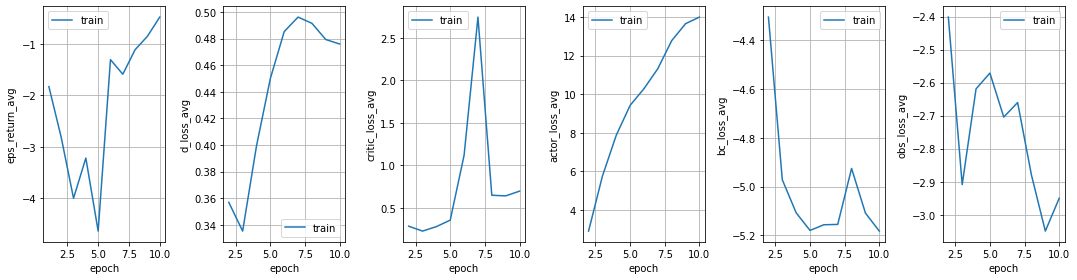

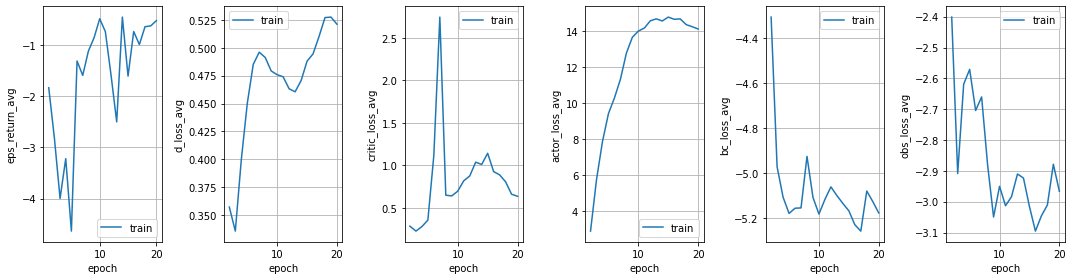

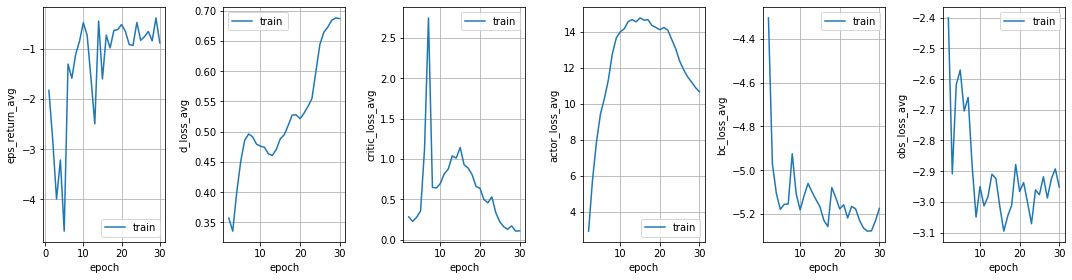

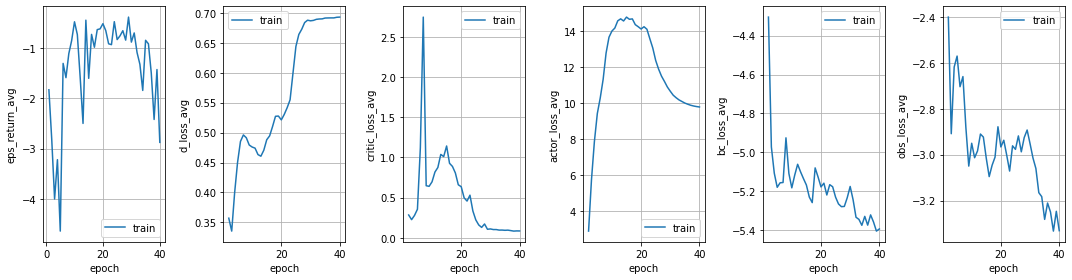

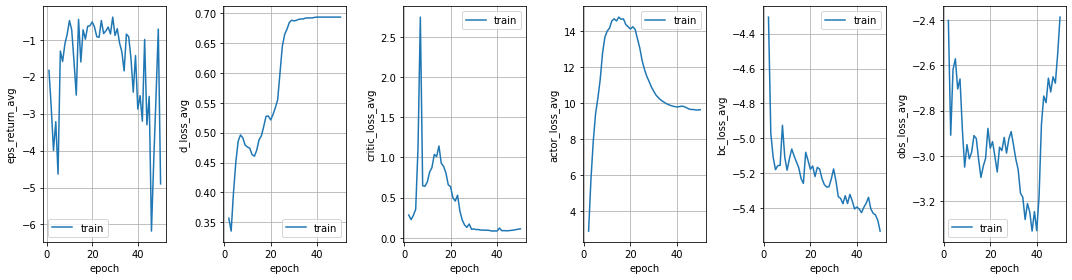

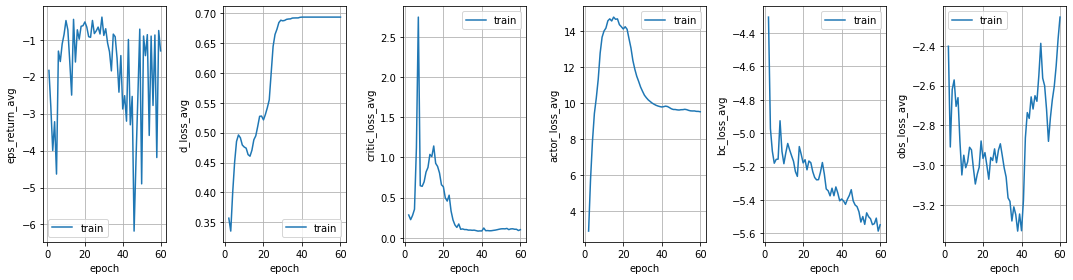

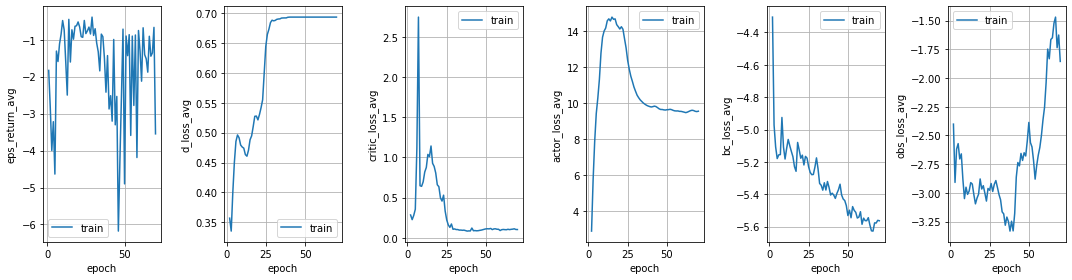

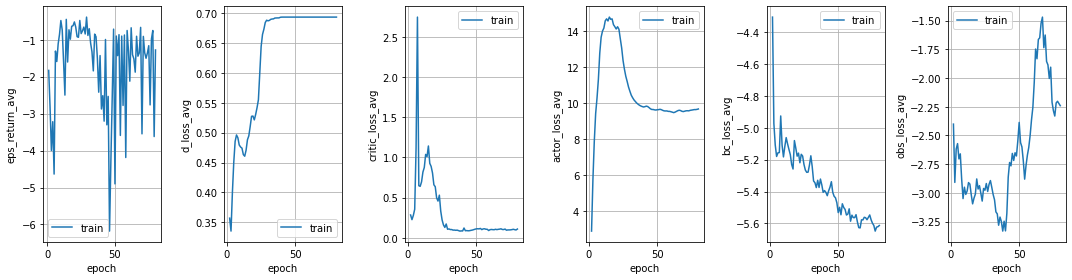

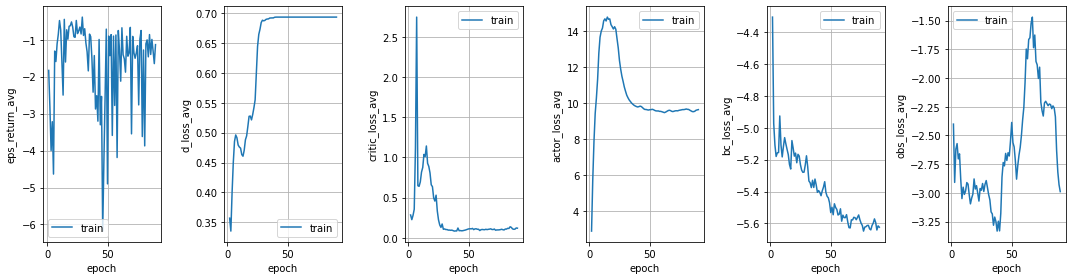

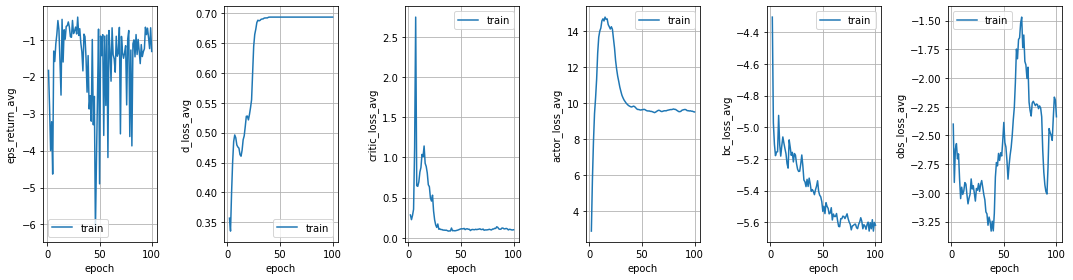

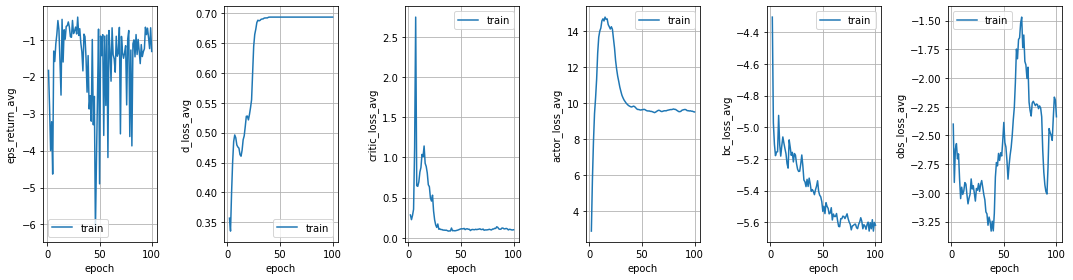

In [14]:
model = main(arglist)